In [1]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google
import tensorflow.keras.backend as K # бэкенд Keras


import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем

In [2]:
# подключаем гугл драйв диск для загрузки файлов
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -R /content/Air

rm: cannot remove '/content/Air': No such file or directory


In [4]:
!unzip -q '/content/drive/My Drive/datasets/images/Самолеты.zip' -d '/content/Air'

In [5]:
ls '/content/Air/База/'

Airplane/  Segment/


In [6]:
# Путь к директории на диске, где находятся изображения
path = '/content/Air/База/'
name_classes = ['Airplane']
num_classes = len(name_classes)
input_shape = (416, 416)

anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors)

In [7]:
# Функция создания полной модели

def create_model(input_shape, num_anchors, use_weights = False, weights_path = 'yolo.h5'):
    w, h = input_shape # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра, описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [8]:
# Функция создания модели YOLOv3
def create_YOLOv3(inputs, num_sub_anchors):

    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок, использующий информацию из предыдущих слоев
    # С помощью слоя Add (Суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3)) # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1) # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2) # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8) # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8) # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4) # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x) # Создаем базовую часть модели YOLOv3
    
    #--------------------
    # Detection часть модели YOLOv3
    #--------------------
    
    # Выделяем три выхода сети, соответсвующих различным уровням сетки
    
    
    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    
    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    
    # 26x26 (обнаружение средних объектов)
    
    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объединить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, используя UpSampling
    x = Concatenate()([x,base_model.layers[152].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    # 52 x 52 (обнаружение маленьких объектов)
    
    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объединить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)  # Увеличиваем размерность до 52 на 52, используя UpSampling
    x = Concatenate()([x,base_model.layers[92].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [9]:
#  Функция создания Residual блока.
def resblock(inputs, num_filters, num_blocks): 
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) # Добавляем блок ConvBL
    for i in range(num_blocks): # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

#  Функция создания блока Conv2D, BatchNormalization, LeakyRelu
def ConvBL(inputs,*args,**kwargs):  
    new_kwargs = {'use_bias': False} # Создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # Добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # Добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x) # Добавляем слой LeakyRelu
    return x


In [10]:
# Функция подсчета ошибки.
def yolo_loss(inputs, num_anchors):
    ignore_thresh = .5 # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3 # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers] # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:] # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] # Задаем маску анкоров для каждого уровня сеток
   
    
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответствуют только OHE представлению класса для данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычисления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычисления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask # Увеличиваем счетчик на единицу и возвращаем ignore_mask
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонент - для значений, которые были верно спредиктены
        # 2 компонент - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки

In [11]:
#  Функция подсчета IoU
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    xy1 = input1[..., :2] # Получаем координаты x,y центра 
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соответствующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    xy2 = input2[..., :2] # Получаем координаты x,y центра 
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соответствующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU

In [12]:
model = create_model(input_shape, num_anchors)
model.summary()

Создана модель YOLOv3. Количество классов: 1.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________

In [13]:
model.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 13, 13, 3, 6) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_4')>]

In [14]:
model.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

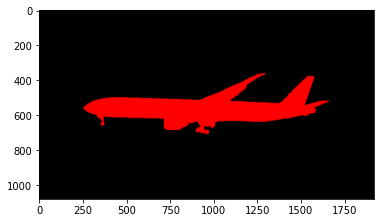

In [15]:
# Открываем файл сегментированной модели
filename = 'airplane_65' # Имя файла
image = Image.open(path+'Segment/'+filename+'.jpg') # Загружаем изображение сегментированной модели
img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения
plt.imshow(image) # Рисуем изображение

minX = 248    minY = 358    maxX = 1665    maxY = 711


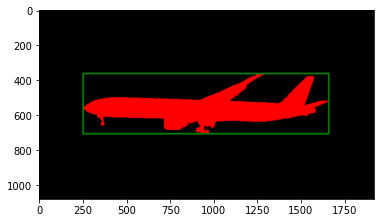

In [16]:
# Находим координаты ограничивающего бокса (ищем по красному параметру в массиве RGB)
image_n = np.array(image) # Переводим в numpy
image_red = image_n[:,:,0] # Оставляем только красный цвет
itemindex = np.array(np.where(image_red > 20 )) # Ищем все элементы, в которых значение красного цвета больше 20
# np.where веренет двумерный кортеж, где первый элемент соответсвует найденным строкам, второй - найденным столбцам
minY = min (itemindex[0]) # minY будет соответствовать минимальному значению в первом элементе itemindex
maxY = max (itemindex[0]) # maxY будет соответствовать максимальному значению в первом элементе itemindex
minX = min (itemindex[1]) # minX будет соответствовать минимальному значению во втором элементе itemindex
maxX = max (itemindex[1]) # maxX будет соответствовать максимальному значению во втором элементе itemindex
print ('minX = ',minX, '    minY = ', minY, '    maxX = ', maxX, '    maxY = ',maxY, sep='') # Выводим найденные значения

# Рисуем ограничивающую рамку
for i in range(10):
  img1.rectangle([minX+i,minY+i,maxX-i,maxY-i], outline = 'green')
plt.imshow(image)

In [17]:
# Запишем всю информацию об объекте в словарь
dictionary = {} # Создаем словарь
class_id = 0 # Номер класса. У нас всего один класс
key = filename # Значение ключа соответсвует имени модели
dictionary[key] = 'Airplane/'+key+'.jpg'+' '+str(minX)+','+str(minY)+','+str(maxX)+','+str(maxY)+','+str(class_id) # Записываем
      # информацию об изображении: Имя_файла minX,minY,maxX,maxY,class_id
print (dictionary) # Выводим словарь

{'airplane_65': 'Airplane/airplane_65.jpg 248,358,1665,711,0'}


Размер исходного изображения:  1920 1080
Размерность входных данных для модели: 416 416
Параметры ограничивающей рамки [[ 248  358 1665  711    0]]


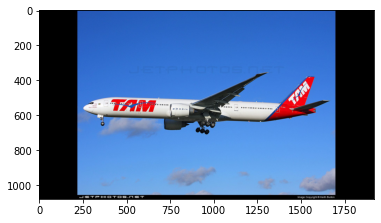

In [18]:
# Загружаем оригинальное изображение
line = dictionary[filename].split() # Сплитим по пробелу значение в словаре: 'Air/airplane_10.jpg 332,360,1661,736,0'
image = Image.open(path+line[0]) # Загружаем файл изображения
iw, ih = image.size # Запоминаем оригинальные размеры изображения
w, h = (416,416) # Устанавливаем ширину и высоту изображения для модели YOLO
box = np.array([np.array(list(map(lambda x: int((float)(x)),box.split(',')))) for box in line[1:]]) # Получаем список параметров для ограничивающих рамок для всех объектов
                                                                                            # на изображении. В нашем случае будет всего одна ограничивающая рамка
plt.imshow(image)   # рисуем изображение        
print ('Размер исходного изображения: ',iw, ih) # Выводим размер исходного изображения
print ('Размерность входных данных для модели:', h, w) # Выводим размеры изображения для входного слоя модели YOLO
print ('Параметры ограничивающей рамки', box) # Выводим параметры ограничивающей рамки

Коэффициент масштабирования:  1.147287341549697
Новый размер изображения:  477 417


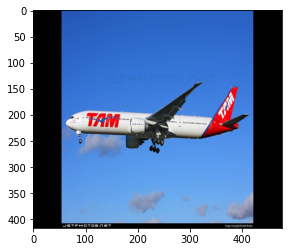

In [19]:
# Аугментация изображения

# Функция получения случайного числа
def rand(a = 0, b = 1):
  return np.random.rand() * (b - a) + a

# Параметры для аугментации изображения
jitter = .3
hue = .1
sat = 1.5
val = 1.5

# Масштабируем изображение
new_ar = w / h * rand(1 - jitter, 1 + jitter) / rand(1 - jitter, 1 + jitter)
scale = rand(.65, 2) 
print ('Коэффициент масштабирования: ', scale)
# Масштабируем изображение
if new_ar < 1:
    nh = int(scale * h)
    nw = int(nh * new_ar)
else:
    nw = int(scale * w)
    nh = int(nw / new_ar)
print ('Новый размер изображения: ',nw, nh)
image1 = image.resize((nw,nh), Image.BICUBIC) # Изменяем размер исходного изображения
plt.imshow(image1) # Рисуем изображение

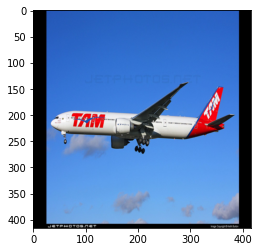

In [20]:
# Приводим к размеру 416 на 416 пикселей для модели YOLO и размещаем в случайном месте на изображении
dx = int(rand(0, w - nw))
dy = int(rand(0, h - nh))
new_image = Image.new('RGB', (w, h), (128,128,128))
new_image.paste(image1, (dx, dy))
image2 = new_image
plt.imshow(image2)

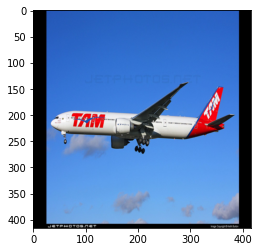

In [21]:
# Случайным образом отображаем изображение по горизонтали
flip = rand() < .5 # с вероятностью 50% получаем параметр отражения картинки
if flip: 
    image2 = image2.transpose(Image.FLIP_LEFT_RIGHT) # Если требуется, то отражаем картику по горизонтали
plt.imshow(image2) # Рисуем картинку

(416, 416, 3)


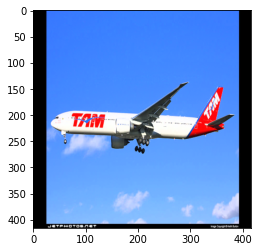

In [22]:
# Случайным образом меняем освещенность, экспозицию, гамму изображения
hue1 = rand(-hue, hue)
sat1 = rand(1, sat) if rand() < .5 else 1 / rand(1, sat)
val1 = rand(1, val) if rand() < .5 else 1 / rand(1, val)
x = rgb_to_hsv(np.array(image2) / 255.)
x[..., 0] += hue1
x[..., 0][x[..., 0] > 1] -= 1
x[..., 0][x[..., 0] < 0] += 1
x[..., 1] *= sat1
x[..., 2] *= val1
x[x > 1] = 1
x[x < 0] = 0
image_data = hsv_to_rgb(x) # numpy array, 0 to 1
print (image_data.shape) # Входные данные для модели YOLO, соответствующие изображению, размерностью 416х416х3
plt.imshow(image_data) # Рисуем изображение

[ 32. 138. 384. 274.   0.]


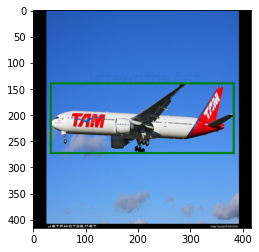

In [23]:
# Корректируем параметры ограничивающей рамки
max_boxes = 5 # Устанавливаем максимальное количество ограничивающих рамок
box_data = np.zeros((max_boxes,5)) # Массив будет хранить параметры ограничивающих рамок. Всего 5 параметров. Первые 4 - координаты minX, minY, maxX, maxY. 5-ый  - номер класса объекта ( в нашем случае всего один класс - самолеты)

box_mod = box.copy()
# Проходим те же модификации с ограничивающей рамкой, что и с изображением: масштабирование, отражение
box_mod[:, [0,2]] = box_mod[:, [0,2]] * nw / iw + dx
box_mod[:, [1,3]] = box_mod[:, [1,3]] * nh / ih + dy
if flip: 
    box_mod[:, [0,2]] = w - box_mod[:, [2,0]]
box_mod[:, 0:2][box_mod[:, 0:2] < 0] = 0
box_mod[:, 2][box_mod[:, 2] > w] = w # Если выходит за ширину
box_mod[:, 3][box_mod[:, 3] > h] = h # Если выходит за высоту
box_w = box_mod[:, 2] - box_mod[:, 0] 
box_h = box_mod[:, 3] - box_mod[:, 1]
box_mod = box_mod[np.logical_and(box_w > 1, box_h > 1)] # Отсекаем маленькие рамки

if len(box_mod) > max_boxes: 
    box_mod = box_mod[:max_boxes] # Если количество ограничивающих рамок больше установленного нами ранее
box_data[:len(box_mod)] = box_mod # Записываем в box_data информацию об ограничивающих рамках аугментированного изображения
print(box_data[0]) # Выводим параметры рамки для аугментированного изображения
img1 = ImageDraw.Draw(image2) # Создаем экземпляр изображения
for i in range(4): # Рисуем ограничивающую рамку
    img1.rectangle([box_data[0][0] + i, box_data[0][1] + i, box_data[0][2] - i, box_data[0][3] - i], outline = 'green')
plt.imshow(image2)

In [24]:
num_layers = 3 # Количество анкоров на каждую сетку (в нашем случае каждая сетка будет иметь анкоры 3 разных размеров)
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Маска дял выбора анкоров
   
real_boxes = np.array(box_data, dtype='float32') # Переводим в numpy
input_shape = np.array((416,416), dtype='int32') # Переводим в numpy

# Определяем центр ограничивающей рамки и ее ширину и высоту
boxes_xy = (real_boxes[:,0:2] + real_boxes[:,2:4]) // 2
boxes_wh = real_boxes[..., 2:4] - real_boxes[..., 0:2]

print('Центр ограничивающей рамки: ', boxes_xy[0])
print('Ширина и высота ограничивающей рамки:', boxes_wh[0])

Центр ограничивающей рамки:  [208. 206.]
Ширина и высота ограничивающей рамки: [352. 136.]


In [25]:
# Переводим параметры ограничивающей рамки в относительные координаты (от 0 до 1)
real_boxes[:, 0:2] = boxes_xy/input_shape[0]
real_boxes[:, 2:4] = boxes_wh/input_shape[1]
print(real_boxes[0])  # Первые два элемента - центр ограничивающей рамки в относительных координатах, 
                      # Вторые два элемента - ширина и высота ограничивающей рамки в относительных размерах
                      # Пятый элемент - класс объекта

[0.5        0.49519232 0.84615386 0.32692307 0.        ]


In [26]:
# Переводим параметры ограничивающей рамки в относительные координаты (от 0 до 1)
real_boxes[:, 0:2] = boxes_xy/input_shape[0]
real_boxes[:, 2:4] = boxes_wh/input_shape[1]
print(real_boxes[0])  # Первые два элемента - центр ограничивающей рамки в относительных координатах, 
                      # Вторые два элемента - ширина и высота ограничивающей рамки в относительных размерах
                      # Пятый элемент - класс объекта

[0.5        0.49519232 0.84615386 0.32692307 0.        ]


In [27]:
# Создадим заготовку под входные слои y_true
cells = [13,26,52]
y_true = [np.zeros((cells[l],cells[l],len(anchor_mask[l]),5+num_classes),dtype='float32') for l in range(num_layers)]
print(y_true[0].shape)
print(y_true[1].shape)
print(y_true[2].shape)
# Таким образом получаем массив из трех сеток разных размеров (13х13, 26х26, 52х52), где каждая ячейка содержит
# три варианта пар анкоров и 5+1 параметр описания каждой из пар анкоров

(13, 13, 3, 6)
(26, 26, 3, 6)
(52, 52, 3, 6)


In [28]:
# из 9 анкоров фиксированного размера требуется найти тот, котоырй максимально охватывает ограничивающую рамку
# для этого пробегаем по всем имеющимся анкорам и считаем IoU всех вариантов

# Площадь, занятая ограничивающей рамкой
wh = boxes_wh[0, :] # Получаем ширину и высоту
box_area = wh[0] * wh[1] # Считаем площадь рамки
print (wh[0],'*',wh[1],'=', box_area)

352.0 * 136.0 = 47872.0


In [29]:
# Площади, которые занимают анкоры
anchor_area = anchors[:, 0] * anchors[:, 1]
print (anchor_area)

[   130    480    759   1830   2790   7021  10440  30888 121598]


In [30]:
# Получим новые параметры анкоров, значения которых не превышают значения высоты и ширины ограничивающей рамки
correct_anchors = []
for elem in anchors:
    correct_anchors.append ([min(elem[0], wh[0]), min(elem[1], wh[1])])
correct_anchors = np.array(correct_anchors)
print(correct_anchors)
# Площади, которые занимают скорректированные анкоры
correct_anchors_area = correct_anchors[:,0] * correct_anchors[:,1]
print(correct_anchors_area)

[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 136.]
 [352. 136.]]
[  130.   480.   759.  1830.  2790.  7021. 10440. 21216. 47872.]


In [31]:
# Подсчитвываем iou всех вариантов
iou = correct_anchors_area / (box_area + anchor_area - correct_anchors_area)
print(iou)

[0.00271557 0.01002674 0.01585478 0.03822694 0.05828041 0.14666193
 0.21808155 0.36869178 0.39369069]


In [32]:
# Определяем позицию лучшего анкора
best_anchor = np.argmax(iou, axis=-1)
print(best_anchor)

8


In [33]:
print('Параметры ограничивающей рамки',real_boxes[0])
for l in range(num_layers): # Пробегаем по всем 3 уровням анкорв
    if best_anchor in anchor_mask[l]: # Если лучший анкор есть в l-ом элементе маски анкоров
        print('Уровень анкора =',l)
        i = np.floor(real_boxes[0,0]*cells[l]).astype('int32') # Определяем позицию ячейки по горизонтали
        print ('i =',i)    
        j = np.floor(real_boxes[0,1]*cells[l]).astype('int32') # Определяем позицию ячейки по вертикали
        print ('j =',j)    
        k = anchor_mask[l].index(best_anchor) # Определяем номер анкора в маске анкоров
        print('Номер поданкора =',k)    
        c = real_boxes[0, 4].astype('int32') # Записываем номер класса объекта
        print ('Номер класса =',c)    
        y_true[l][j, i, k, 0:4] = real_boxes[0, 0:4] # Записываем 4 параметра объекта: координаты центра, ширина и высота
        y_true[l][j, i, k, 4] = 1 # Записываем вероятность того, что найден объект (для обучающей выборки всегда 1)
        y_true[l][j, i, k, 5+c] = 1  # В позицию 5+с записываем класс объекта (ohe)
        break

print(y_true[l][j,i,...])

Параметры ограничивающей рамки [0.5        0.49519232 0.84615386 0.32692307 0.        ]
Уровень анкора = 0
i = 6
j = 6
Номер поданкора = 2
Номер класса = 0
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.5        0.49519232 0.84615386 0.32692307 1.         1.        ]]


In [34]:
# Функция генерации данных
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    while True:
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        for b in range(batch_size): # Пробегаем по всему batch_size
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            image, box = augmentation(annotation_lines[i]) # Делаем аугментацию картинок и ограничивающих рамок
            image_data.append(image) # Добавляем полученную картинку в результирующий массив 
            box_data.append(box) # Добавляем полученную ограничивающую рамку в массив bounfing_box
            i = (i+1) % n # Обновляем значение индекса (не превышая общего количества элементов)
        image_data = np.array(image_data) # Преобразуем в numpy
        box_data = np.array(box_data) # Преобразуем в numpy
        y_true = get_y(box_data, anchors, input_shape) # По значению ограничивающей рамки получаем y_true        
        yield [image_data, *y_true], np.zeros(batch_size) # Возвращаем порцию данных для обучения

In [35]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {'jitter' : .3, 'hue' : .1, 'sat' : 1.5, 'val' : 1.5}
    data = data.split() # Сплитим входную строку словаря
    image = Image.open(path + data[0]) # Открываем изображение самолета
    width_i, height_i = image.size # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2] # Получаем ширину и высоту входного изображения для модели RetinaNet
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтали
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтали
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те значения, которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    # Возвращаем измененное изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированное изображение и bounding_box

In [36]:
# Функция подсчета y
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32') # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32') # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] # Получаем высоту и ширину bounding_box в относительных значениях

    m = true_boxes.shape[0] # Получаем количество элементов в batch_size
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue # Выходим, если она нулевая
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [37]:
# Получение координат ограничивающей рамки
def getXY(image):
    image_red = np.array(image)[:,:,0]  # Считываем красный канал изображения
    indexes = np.where(image_red > 20) # Получаем индексы пикселей красного цвета
    
    # Возвращаем координаты ограничивающей рамки [Xmin, Ymin, Xmax, Ymax]
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

# Создание словаря {Имя файла: параметры файла}
def get_dict():
    dictionary = {} # Создаем пустой словарь
    files = os.listdir(path + 'Segment/') # Получаем список файлов
    class_id = 0 # Задаем параметр номера класса (у нас всего один класс "Самолет")
    for f in files:
        image = Image.open(path + 'Segment/'+f) # Открываем сегментированное изображение
        xy = getXY(image) # Получаем координаты ограничивающей рамки
        key = f # Получаем ключ словаря (имя файла)
        
        # Записываем значение в словарь
        dictionary[key] = 'Airplane/'+key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)
    print ('Завершена обработка класса: ', name_classes[0]) # Выводим сообщение о заврешении обработки
        
    return dictionary # Возвращаем словарь

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

In [38]:
dictionary = get_dict()
dictionary_np = np.array(list(dictionary.values())) #Создаем numpy массив из значений словаря

# Выведем информацию из словаря и из его numpy представления
print(dictionary['airplane_2.jpg'])
print(dictionary_np[0])

Завершена обработка класса:  Airplane
Airplane/airplane_2.jpg 210,266,1715,742,0
Airplane/airplane_594.jpg 368,366,1551,751,0


In [39]:
val_split = 0.1 # Коэффициент разделения на обучающую и проверочную выборку

# Перемешаем значения в массиве
np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)

num_val = int(len(dictionary_np) * val_split) # Количество элементов проверочной выборки
num_train = len(dictionary_np) - num_val # Количество элементов обучающей выборки
print (num_val)
print (num_train)

100
900


In [40]:
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [41]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета

# Запускаем процесс обучения на 50 эпохах
history = model.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
112/112 [==============================] - 113s 896ms/step - loss: 1701.3277 - val_loss: 1009.5002
Epoch 2/50
112/112 [==============================] - 98s 879ms/step - loss: 70.3830 - val_loss: 79.3799
Epoch 3/50
112/112 [==============================] - 98s 880ms/step - loss: 40.2641 - val_loss: 38.7751
Epoch 4/50
112/112 [==============================] - 98s 883ms/step - loss: 31.2340 - val_loss: 28.8261
Epoch 5/50
112/112 [==============================] - 98s 879ms/step - loss: 26.2576 - val_loss: 28.1690
Epoch 6/50
112/112 [==============================] - 98s 880ms/step - loss: 23.3136 - val_loss: 22.8821
Epoch 7/50
112/112 [==============================] - 99s 893ms/step - loss: 21.3451 - val_loss: 21.6507
Epoch 8/50
112/112 [==============================] - 99s 889ms/step - loss: 20.0659 - val_loss: 19.7524
Epoch 9/50
112/112 [==============================] - 98s 882ms/step - loss: 18.9849 - val_loss: 47.9426
Epoch 10/50
112/112 [=============================

In [42]:
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [43]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета

# Запускаем процесс обучения на 50 эпохах
history = model.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
112/112 [==============================] - 112s 919ms/step - loss: 7.4765 - val_loss: 6.5340
Epoch 2/50
112/112 [==============================] - 99s 887ms/step - loss: 6.4317 - val_loss: 5.9852
Epoch 3/50
112/112 [==============================] - 98s 879ms/step - loss: 6.0004 - val_loss: 5.3456
Epoch 4/50
112/112 [==============================] - 99s 886ms/step - loss: 5.8837 - val_loss: 5.4197
Epoch 5/50
112/112 [==============================] - 99s 891ms/step - loss: 5.3963 - val_loss: 5.0815
Epoch 6/50
112/112 [==============================] - 99s 888ms/step - loss: 5.4135 - val_loss: 4.8499
Epoch 7/50
112/112 [==============================] - 98s 882ms/step - loss: 5.1696 - val_loss: 5.8159
Epoch 8/50
112/112 [==============================] - 98s 884ms/step - loss: 5.1694 - val_loss: 4.5534
Epoch 9/50
112/112 [==============================] - 98s 885ms/step - loss: 5.1569 - val_loss: 4.3408
Epoch 10/50
112/112 [==============================] - 98s 885ms/step - 

In [44]:
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [45]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета

# Запускаем процесс обучения на 50 эпохах
history = model.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
112/112 [==============================] - 112s 916ms/step - loss: 3.4578 - val_loss: 3.2078
Epoch 2/50
112/112 [==============================] - 101s 904ms/step - loss: 3.3376 - val_loss: 3.0555
Epoch 3/50
112/112 [==============================] - 100s 902ms/step - loss: 3.2171 - val_loss: 3.0591
Epoch 4/50
112/112 [==============================] - 100s 898ms/step - loss: 3.1697 - val_loss: 2.9786
Epoch 5/50
112/112 [==============================] - 101s 904ms/step - loss: 3.2994 - val_loss: 3.1598
Epoch 6/50
112/112 [==============================] - 100s 899ms/step - loss: 3.3496 - val_loss: 2.9171
Epoch 7/50
112/112 [==============================] - 100s 899ms/step - loss: 3.1190 - val_loss: 3.0441
Epoch 8/50
112/112 [==============================] - 101s 906ms/step - loss: 3.1828 - val_loss: 2.9845
Epoch 9/50
112/112 [==============================] - 100s 899ms/step - loss: 3.1506 - val_loss: 2.9412
Epoch 10/50
112/112 [==============================] - 100s 899m

In [46]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета

# Запускаем процесс обучения на 50 эпохах
history = model.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 50,
                    verbose = 1,
                    initial_epoch = 0
                    )

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
225/225 [==============================] - 102s 455ms/step - loss: 3.1012 - val_loss: 2.9309
Epoch 2/50
225/225 [==============================] - 104s 463ms/step - loss: 3.1115 - val_loss: 2.8615
Epoch 3/50
225/225 [==============================] - 104s 464ms/step - loss: 3.0510 - val_loss: 2.9038
Epoch 4/50
225/225 [==============================] - 104s 466ms/step - loss: 3.0492 - val_loss: 2.8218
Epoch 5/50
225/225 [==============================] - 104s 463ms/step - loss: 3.0256 - val_loss: 2.7759
Epoch 6/50
225/225 [==============================] - 104s 463ms/step - loss: 3.0319 - val_loss: 2.9255
Epoch 7/50
225/225 [==============================] - 102s 454ms/step - loss: 3.0265 - val_loss: 2.8594
Epoch 8/50
225/225 [==============================] - 102s 455ms/step - loss: 3.0143 - val_loss: 2.6759
Epoch 9/50
225/225 [==============================] - 102s 456ms/step - loss: 2.9929 - val_loss: 2.7898
Epoch 10/50
225/225 [==============================] - 102s 454m